In [1]:
import numpy as np
import pandas as pd
#import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from datetime import datetime
from tqdm.auto import tqdm, trange
from collections import Counter
from sklearn.preprocessing import LabelEncoder, StandardScaler
import random
import os

from sklearn.metrics import recall_score
from catboost import Pool, CatBoostClassifier

%matplotlib inline

In [2]:
def seed_everything(seed = 1234):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    # torch.manual_seed(seed)
    # torch.cuda.manual_seed(seed)
    # torch.backends.cudnn.deterministic = True

SEED = 42
seed_everything(SEED)

## 1 Обработка данных

In [3]:
DATA_PATH = '../data/'
df_train = pd.read_csv(os.path.join(DATA_PATH, "train_dataset_train.csv"), index_col='contract_id')
df_test = pd.read_csv(os.path.join(DATA_PATH, "sample_solution.csv"), index_col='contract_id')

df_named = pd.read_csv(os.path.join(DATA_PATH, "named.csv"))
df_type_contract = pd.read_csv(os.path.join(DATA_PATH, "type_contract.csv"), index_col='contract_id')
df_log = pd.read_csv(os.path.join(DATA_PATH, "log.csv"))

### 1.1 Таблицы df_train и df_test

In [4]:
print('Test: Число записей train/test:', len(df_train), len(df_test))

Test: Число записей train/test: 5992 810


In [5]:
df_train.sample(3)

,blocked
contract_id,
35258,0
30289,0
36694,0


In [6]:
df_train.blocked.value_counts()

0    5294
1     698
Name: blocked, dtype: int64

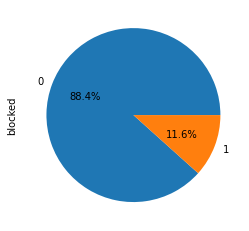

In [7]:
df_train.blocked.value_counts().plot(kind='pie', autopct='%.1f%%');

Объединим train и test в один датасет, добавив колонку train (1,0) с обозначением источника.

In [8]:
df_users = df_train.copy()
df_users = pd.concat([df_train, df_test])
df_users['train'] = 0
df_users.loc[df_train.index, 'train'] = 1
df_users.loc[df_test.index, 'blocked'] = None
df_users

,blocked,train
contract_id,,
7780,0.0,1
7785,0.0,1
7794,0.0,1
7795,0.0,1
7798,0.0,1
...,...,...
4258,NaN,0
4259,NaN,0
4260,NaN,0


Убедимся, что нет дублей, пересечений train/test и id уникальны

In [9]:
assert len(df_users) == len(set(df_users.index))
assert len(df_users) == len(df_train) + len(df_test)

### 1.2 Таблица type_contract

In [10]:
df_type_contract.head(3)

,day_or_month_contract
contract_id,
7780,0
3996,0
7785,0


В этой таблице есть строки с одинаковыми индексами (и одинаковыми значениями), поэтому сразу удалим лишние дубли.

In [11]:
def remove_duplicated_index_rows(df):
    mask = df.index.duplicated(keep='last')
    if sum(mask):
        print(f'Удаляем {sum(mask)} строк с дублем индекса.')
        df = df[~mask]
    return df

df_type_contract = remove_duplicated_index_rows(df_type_contract)

Удаляем 5 строк с дублем индекса.


In [12]:
print('Число None:', df_type_contract.isna().sum().sum())
print('Число значений поля day_or_month_contract:', Counter(df_type_contract.day_or_month_contract))
print('Число клиентов в df_type_contract:', len(df_type_contract))
print('Число клиентов df_type_contract, отсутствующих в df_users:', len(set(df_type_contract.index.unique()) - set(df_users.index)))
print('Число клиентов df_users без значения:', len(set(df_users.index) -  set(df_type_contract.index.unique())))

Число None: 0
Число значений поля day_or_month_contract: Counter({0: 4017, 1: 2783})
Число клиентов в df_type_contract: 6800
Число клиентов df_type_contract, отсутствующих в df_users: 0
Число клиентов df_users без значения: 2


**Объединим с df_users**

In [13]:
df_users = pd.merge(df_users, df_type_contract, on='contract_id', how='left')
df_users.day_or_month_contract = df_users.day_or_month_contract.fillna(0)

In [14]:
# переименуем, чтобы поля были более читабельные
df_users.rename(columns={'day_or_month_contract': 'contract_type'}, inplace=True)

In [15]:
df_users

,blocked,train,contract_type
contract_id,,,
7780,0.0,1,0.0
7785,0.0,1,0.0
7794,0.0,1,0.0
7795,0.0,1,1.0
7798,0.0,1,0.0
...,...,...,...
4258,NaN,0,1.0
4259,NaN,0,1.0
4260,NaN,0,0.0


In [16]:
df_users[df_users.train==1].corr()

,blocked,train,contract_type
blocked,1.000000,NaN,0.006295
train,NaN,NaN,NaN
contract_type,0.006295,NaN,1.000000


day_or_month_contract малокоррелирует с таргетом. Возможно есть совместная взаимосвязь с данными из других таблиц

## 1.3 Таблица df_log - события

In [17]:
df_log.head(5)

,contract_id,event_date,event_type
0,36294,2021-03-28 16:24:30,Добавление в Обращались с номеров
1,36294,2021-03-28 16:27:41,Обращение в службу заботы о клиентах
2,36294,2021-03-28 16:29:56,Выключение IPTV-пакета
3,36294,2021-03-28 16:29:56,Включение IPTV-пакета
4,36294,2021-03-28 16:35:04,Обращение в службу заботы о клиентах


In [18]:
print('Число записей:', len(df_log))
print('Число null:', df_log.isna().sum().sum())
print('Число клиентов в df_log:', df_log.contract_id.nunique())
print('Число клиентов df_log, отсутствующих в df_users:', len(set(df_log.contract_id.unique()) - set(df_users.index)))
print('Число клиентов df_users без событий:', len(set(df_users.index) -  set(df_log.contract_id.unique())))

Число записей: 25274
Число null: 0
Число клиентов в df_log: 4311
Число клиентов df_log, отсутствующих в df_users: 0
Число клиентов df_users без событий: 2491


Отсортируем события по дате

In [19]:
df_log.event_date = pd.to_datetime(df_log.event_date) #.dt.date
df_log = df_log.sort_values(by=['event_date', 'contract_id'])
df_log = df_log.reset_index(drop=True)

А теперь уберем время, оставив только дату

In [20]:
df_log.event_date = df_log.event_date.dt.date

Число событий на одного пользователя:

53476     354
134020    235
209464    154
3859      148
12654      86
         ... 
116802      1
44246       1
4256        1
10153       1
3851        1
Name: contract_id, Length: 4311, dtype: int64


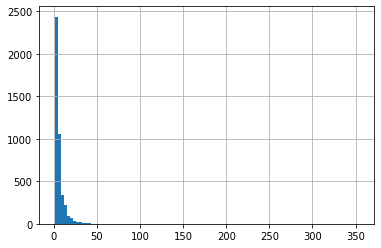

In [21]:
print(df_log.contract_id.value_counts())
df_log.contract_id.value_counts().hist(bins=100);

В таблице всего 16 пользователей с числом событий > 40, причем из них только один в тестовой выборке. Поэтому можно будет далее ограничить данные последними 40 событиями, убрав выбросы.

In [22]:
MAX_EVENTS_PER_USER = 40
df_users.loc[[k for k, v in df_log.contract_id.value_counts().items() if v > MAX_EVENTS_PER_USER]]

,blocked,train,contract_type
contract_id,,,
53476,0.0,1,0.0
134020,1.0,1,1.0
209464,1.0,1,0.0
3859,NaN,0,0.0
12654,0.0,1,1.0
11099,0.0,1,0.0
8700,0.0,1,0.0
42601,0.0,1,1.0
52535,0.0,1,0.0


Оставим только по 40 последних событий каждого пользователя. 

In [23]:
for user, count in df_log.contract_id.value_counts().items():
    if count > MAX_EVENTS_PER_USER:
        drop_ids = df_log[df_log.contract_id == user].index[ : -MAX_EVENTS_PER_USER]
        df_log = df_log.drop(drop_ids)

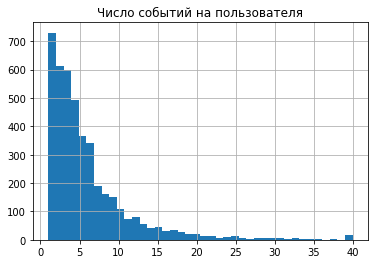

In [24]:
df_log.contract_id.value_counts().hist(bins=40).set_title('Число событий на пользователя');

преобразуем название события в код с возможностью при желании сделать обратное декодирование

In [25]:
le_event = LabelEncoder()
df_log.event_type = le_event.fit_transform(df_log.event_type)

In [26]:
df_log

,contract_id,event_date,event_type
0,195133,2021-03-01,22
1,160127,2021-03-01,23
2,14691,2021-03-01,46
3,160127,2021-03-01,22
4,3946,2021-03-01,49
...,...,...,...
25269,53432,2021-04-29,34
25270,50543,2021-04-29,22
25271,49920,2021-04-29,46
25272,49469,2021-04-29,46


**Добавим в `df_users` поле `has_events` со значениями 1, 0 и поле `events_count` - 0...MAX_EVENTS_PER_USER**

In [27]:
df_users['has_events'] = 0
df_users.loc[df_log.contract_id.unique(), 'has_events'] = 1
#проверка:
print(df_users.has_events.value_counts())

1    4311
0    2491
Name: has_events, dtype: int64


In [28]:
df_users['events_count'] = 0
for user, count in df_log.contract_id.value_counts().items():
    df_users.loc[user, 'events_count'] = count

In [29]:
df_users.head(3)

,blocked,train,contract_type,has_events,events_count
contract_id,,,,,
7780,0.0,1,0.0,1,9
7785,0.0,1,0.0,1,1
7794,0.0,1,0.0,0,0


#### Сделаем таблицу `df_user_event` с количество событий каждого типа для каждого пользователя

In [30]:
df_user_event = pd.DataFrame(np.zeros([len(df_users), len(le_event.classes_)]), index=df_users.index, columns=range(len(le_event.classes_)))
for i, row in tqdm(df_log.iterrows(), total=len(df_log)):
    df_user_event.loc[row.contract_id, row.event_type] += 1

  0%|          | 0/24373 [00:00<?, ?it/s]

In [31]:
assert len(df_log) == df_user_event.sum().sum() == df_users.events_count.sum(), 'Проверка: сумма значения должна быть равна числу записей в логе'
df_user_event

,0,1,2,3,4,5,6,7,8,9,...,93,94,95,96,97,98,99,100,101,102
contract_id,,,,,,,,,,,,,,,,,,,,,
7780,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7785,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7794,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7795,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7798,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4258,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4259,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Табица рязряженная, потому и видно одни нули. Суммарное число событий не изменилось:

In [32]:
df_user_event.sum().sum()

24373.0

## 1.4 Таблица df_named - посещения конкуретнов

In [33]:
df_named

,date,url,contract_id
0,17-Apr-2021,webmail.sampo.ru,101397
1,17-Apr-2021,webmail.sampo.ru,179624
2,17-Apr-2021,tvip-provision.sampo.ru,190335
3,17-Apr-2021,tvip-provision.sampo.ru,61670
4,17-Apr-2021,tvip-provision.sampo.ru,39370
...,...,...,...
10646532,01-Apr-2021,_sip._udp.048056.16.rt.ru,164026
10646533,01-Apr-2021,048056.16.rt.ru,133945
10646534,01-Apr-2021,camera.rt.ru,67986
10646535,01-Apr-2021,camera.rt.ru,31576


In [34]:
print('Число записей:', len(df_named))
print('Число null:', df_named.isna().sum().sum())
print('Число клиентов в df_named:', df_named.contract_id.nunique())
print('Число клиентов df_named, отсутствующих в df_users:', len(set(df_named.contract_id.unique()) - set(df_users.index)))
print('Число клиентов df_users без записей:', len(set(df_users.index) -  set(df_named.contract_id.unique())))

Число записей: 10646537
Число null: 0
Число клиентов в df_named: 196148
Число клиентов df_named, отсутствующих в df_users: 192843
Число клиентов df_users без записей: 3497


Удалим записи всех пользователей, не входящих в train и test

Много информации по неинтересным нам пользователям. Оставим только данные для пользователей из train и test датасетов

In [35]:
df_named = df_named[df_named.contract_id.isin(df_users.index)]
df_named = df_named.copy()

In [36]:
print('Число записей:', len(df_named))
print('Число клиентов в df_named:', df_named.contract_id.nunique())
print('Число клиентов df_named, отсутствующих в df_users:', len(set(df_named.contract_id.unique()) - set(df_users.index)))
print('Число клиентов df_users без записей:', len(set(df_users.index) -  set(df_named.contract_id.unique())))

Число записей: 145903
Число клиентов в df_named: 3305
Число клиентов df_named, отсутствующих в df_users: 0
Число клиентов df_users без записей: 3497


Преобразуем тип даты и отсортируем по датам. Даты в таблице (для нужных нам пользователей) - от 2021-03-26 до 2021-04-30

In [37]:
df_named['date'] = pd.to_datetime(df_named['date'], format='%d-%b-%Y')
df_named = df_named.sort_values(by=['date', 'contract_id'])
df_named = df_named.reset_index(drop=True)

In [38]:
df_named

,date,url,contract_id
0,2021-03-26,fnc.rt.ru,3464
1,2021-03-26,itv.svc.iptv.rt.ru,3495
2,2021-03-26,static.iptv.rt.ru,3495
3,2021-03-26,cnt-lbrc-itv02.svc.iptv.rt.ru,3495
4,2021-03-26,cnt-odcv-itv03.svc.iptv.rt.ru,3495
...,...,...,...
145898,2021-04-29,data.sampo.ru,54296
145899,2021-04-29,fnc.rt.ru,54343
145900,2021-04-30,keyastromgate.rt.ru,48691
145901,2021-04-30,mlk.rt.ru,48691


**Добавим в `df_users` поля `has_visits` и `visits_count`**

In [39]:
df_users['has_visits'] = 0
df_users.loc[df_named.contract_id.unique(), 'has_visits'] = 1
#проверка:
print(df_users.has_visits.value_counts())

0    3497
1    3305
Name: has_visits, dtype: int64


In [40]:
df_users['visits_count'] = 0
for user, count in df_named.contract_id.value_counts().items():
    df_users.loc[user, 'visits_count'] = count

#### Сделаем таблицу df_user_url с помощью tfidf векторизации токенов поддоменов всех посещенных url для каждого пользователя


Можно и просто счетчик записей, как с событиями. Но решил испытать tfidf и метрики в результате получились повыше.

Разобъем url на поддомены, и объедиминим данные по пользователям

In [41]:
user_tokens = {u:[] for u in df_users.index}

for i, row in tqdm(df_named.iterrows(), total=len(df_named)):
    parts = row.url.split('.')
    tokens = parts[:-1] + ['.'.join(parts[-2:])] #дополнительно добавляю верхний домен
    user_tokens[row.contract_id].extend(tokens)

  0%|          | 0/145903 [00:00<?, ?it/s]

Теперь сделаем tfidf векторизацию посещенных url. Токенами будут поддомены. Результат преобразуем в таблицу `df_user_url`

In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer

user_ids = []
data = []
for user, tokens in user_tokens.items():
    user_ids.append(user)
    data.append(' '.join(tokens))


vect = TfidfVectorizer(min_df=10)
vectorized_data = vect.fit_transform(data).todense()

df_user_url = pd.DataFrame(data=vectorized_data, index=user_ids)
df_user_url.index.rename('contract_id', inplace=True)
df_user_url

,0,1,2,3,4,5,6,7,8,9,...,117,118,119,120,121,122,123,124,125,126
contract_id,,,,,,,,,,,,,,,,,,,,,
7780,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.008178,0.027248,0.0,0.0,0.262364,0.0,0.032151,0.0,0.0,0.0
7785,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
7794,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
7795,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
7798,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4258,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
4259,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.042800,0.0,0.0,0.142054,0.0,0.000000,0.0,0.0,0.0
4260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.072696,0.080737,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0


## 2 Объединение данных

In [43]:
assert len(df_users) == len(df_user_event) == len(df_user_url)
assert set(df_users.index) == set(df_user_event.index) == set(df_user_url.index)

Переименуем нумерованные колонки, чтобы не путат друг с другом. Если понадобится например получить имя признака при анализе feature importance.

In [44]:
df_user_event.columns = [f'E_{c}'for c in df_user_event.columns]
df_user_url.columns = [f'U_{c}'for c in df_user_url.columns]

In [45]:
df = pd.merge(df_users, df_user_event, on='contract_id', how='left')
df = pd.merge(df, df_user_url, on='contract_id', how='left')

In [46]:
# Проверка
assert len(df) == len(df_users)
assert df.shape[1] == df_users.shape[1] + df_user_event.shape[1] + df_user_url.shape[1]

In [47]:
df.to_csv('df_parsed 4 new.csv')

In [48]:
df

,blocked,train,contract_type,has_events,events_count,has_visits,visits_count,E_0,E_1,E_2,...,U_117,U_118,U_119,U_120,U_121,U_122,U_123,U_124,U_125,U_126
contract_id,,,,,,,,,,,,,,,,,,,,,
7780,0.0,1,0.0,1,9,1,83,0.0,0.0,0.0,...,0.008178,0.027248,0.0,0.0,0.262364,0.0,0.032151,0.0,0.0,0.0
7785,0.0,1,0.0,1,1,1,10,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
7794,0.0,1,0.0,0,0,0,0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
7795,0.0,1,1.0,1,7,0,0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
7798,0.0,1,0.0,1,3,0,0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4258,NaN,0,1.0,1,3,0,0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
4259,NaN,0,1.0,0,0,1,484,0.0,0.0,0.0,...,0.000000,0.042800,0.0,0.0,0.142054,0.0,0.000000,0.0,0.0,0.0
4260,NaN,0,0.0,1,3,1,9,0.0,0.0,0.0,...,0.072696,0.080737,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0


### 3 Функции обучения и оценки

In [49]:
#from imblearn.over_sampling import RandomOverSampler, SMOTE
#from sklearn.preprocessing import StandardScaler

def preprocess(df, random_seed, split_val=True, scaler=None, resampler=None):
    y_train = df[df.train == 1].blocked
    X_train = df[df.train == 1].drop(['train', 'blocked'], axis=1)
    X_test = df[df.train == 0].drop(['train', 'blocked'], axis=1)
    
    if split_val:
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, random_state=random_seed)
    
    if resampler:
        obj = resampler(random_state=random_seed)
        X_train, y_train = obj.fit_resample(X_train, y_train)
        
    if scaler:
        obj = scaler()
        X_train = obj.fit_transform(X_train)
        X_test = obj.transform(X_test)
        if split_val:
            X_val = obj.transform(X_val)
        
    if split_val:
        return X_train, y_train, X_val, y_val, X_test
    else:
        return X_train, y_train, X_test

'''
Использование функции (для train/val/test и train/test):

X_train, y_train, X_val, y_val, X_test = preprocess(df, SEED)
X_train, y_train, X_test = preprocess(df, SEED, split_val=False)
''';

In [50]:
def my_metric(true, pred):
    return recall_score(true, pred, average='macro')

In [51]:
# Оценивает метрику модели, прогнав её N раз на разных разбивках и random_state модели. Печатает и возвращает средний скор
def evaluate_model_mean_score_on_splits(params, n=10, verbose=False):
    print(params)
    scores = []
    best_iters = []
    pbar = tqdm(range(n))
    for seed in pbar:
        X_train, y_train, X_val, y_val, X_test = preprocess(df, seed)
        train_pool = Pool(X_train, y_train)
        val_pool = Pool(X_val, y_val)

        model = CatBoostClassifier(verbose=verbose, random_state=seed, **params)
        pred = model.fit(train_pool, eval_set=val_pool).predict(val_pool)
        score = my_metric(y_val, pred)
        best_iters.append(model.get_best_iteration())
        scores.append(score)
        pbar.set_description(f"mean val score: {np.mean(scores):.4f}, mean best_iter: {np.mean(best_iters):.0f}")
    score = np.mean(scores)
    print(f'Число итераций: {np.min(best_iters)}-{np.max(best_iters)}, mean {np.mean(best_iters):.0f}')
    print('Средний скор по {} сидам: {:.4f}'.format(n, score))
    return score

In [52]:
# class weights использовать только при отключенном ресэмплере
class_weights = df[df.train==1].blocked.value_counts().values[::-1] / len(df[df.train==1])

## 4 Модель

В этой версии гиперпараметры особо не настраивал. Только лосс и глубину. class_weights помогает исправить дисбаланс классов. 

Взял умеренно большое число итераций модели и параметр use_best_model, который возвращает итерацию модели с максимальной eval метрикой. Чтобы умеьньшить влияние train/val разбиения обучаю N раз на разных разбивках и усредняю результат.

In [53]:
params = {'n_estimators': 1500, 'depth': 1, 'loss_function': 'MultiClass', 'class_weights': class_weights,
          'use_best_model': True, 'eval_metric': 'TotalF1:average=Macro',
         }
N = 100
AVERAGE_ON_PROBA = True

In [54]:
proba_sum = None
pred_sum = None
print('Параметры:', params)
val_scores = []
pbar = tqdm(range(N))
for seed in pbar:
    X_train, y_train, X_val, y_val, X_test = preprocess(df, seed)
    train_pool = Pool(X_train, y_train)
    val_pool = Pool(X_val, y_val)        
    
    model = CatBoostClassifier(verbose=False, random_state=seed, **params)
    
    proba = model.fit(train_pool, eval_set=val_pool).predict_proba(X_test)
    if proba_sum is None:
        proba_sum = np.zeros_like(proba)
        pred_sum = np.zeros([len(X_test)])
    proba_sum += proba
    pred_sum += np.argmax(proba, axis=1)
    
    val_scores.append(my_metric(y_val, model.predict(X_val)))
    pbar.set_description(f"val mean score: {np.mean(val_scores):.4f}")

pred_avg_pred = (pred_sum / N).round().astype(int)
pred_avg_proba = np.argmax(proba_sum, axis=1) 

Параметры: {'n_estimators': 1500, 'depth': 1, 'loss_function': 'MultiClass', 'class_weights': array([0.11648865, 0.88351135]), 'use_best_model': True, 'eval_metric': 'TotalF1:average=Macro'}


  0%|          | 0/100 [00:00<?, ?it/s]

In [61]:
pred = pred_avg_proba if AVERAGE_ON_PROBA else pred_avg_pred
print('Различий в усреднении по proba и по pred:', (pred_avg_pred != pred_avg_proba).sum())

Различий в усреднении по proba и по pred: 1


## 5 Экспорт в файл

In [62]:
filename = 'out_submit.csv'

In [63]:
cids = df[df.train==0].index

my_submit = pd.DataFrame({'contract_id': cids, 'blocked': pred})
my_submit.to_csv(filename, index=False)
my_submit.head()

,contract_id,blocked
0,3453,1
1,3454,1
2,3455,0
3,3456,1
4,3457,0
